# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split


In [2]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### 1) Data Understanding

In [3]:
print("Portfolio Size = {}".format(portfolio.shape))
portfolio.head()

Portfolio Size = (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print("Profile Size = {}".format(profile.shape))
profile.head()

Profile Size = (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
print("Transcript Size = {}".format(transcript.shape))
transcript.head()

Transcript Size = (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### 2) Data Wrangling

### For Portfolio

In [9]:
channels_set=set()
for i in portfolio['channels']:
    channels_set.update(set(i))
channels_set

{'email', 'mobile', 'social', 'web'}

In [10]:
for i in channels_set:
    portfolio[i]=portfolio['channels'].apply(lambda x: i in x).map({True:1,False:0})
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,mobile,web,social,email
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1


In [11]:
portfolio=portfolio.drop(['channels'],axis=1)
portfolio.head()

,reward,difficulty,duration,offer_type,id,mobile,web,social,email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1


### For Profile

In [12]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [13]:
profile['gender'].fillna("NA",inplace=True)
profile['income'].fillna(profile['income'].mean(),inplace=True)
profile.head()

,gender,age,id,became_member_on,income
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000
4,NA,118,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568


In [14]:
profile['year']=profile['became_member_on'].apply(lambda x: int(str(x)[:4]))
profile['month']=profile['became_member_on'].apply(lambda x: int(str(x)[4:6]))
profile['day']=profile['became_member_on'].apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile = profile.drop(['became_member_on'],axis=1)
profile.head()

,gender,age,id,income,year,month,day,member_date
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,NA,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


### For Transcript

In [15]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [16]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 
transcript['time'] = transcript['time'].apply(lambda x: int(x))
transcript.head()

,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


### 3) Data Analysis

### Gender Analysis

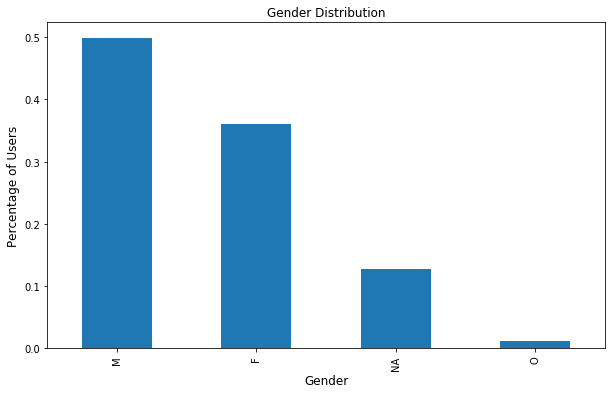

In [17]:
profile.gender.value_counts(normalize=True).plot(kind='bar',figsize=(10,6))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 12)
plt.xlabel('Gender', fontsize = 12);

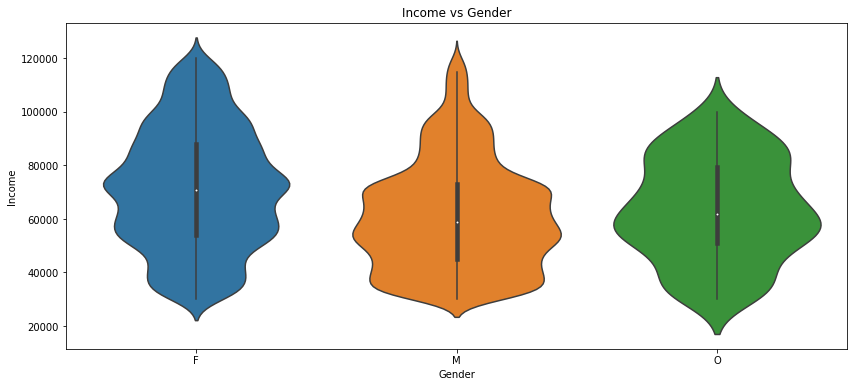

In [18]:
plt.figure(figsize=(14, 6))
sns.violinplot(x=profile[profile['gender'] != 'NA']['gender'], y=profile['income'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Roughly half of the people in the Starbucks population are males, while females, unknown, and other genders make up the rest of the population. Females have most of their users with incomes between 55,000 dollars to 90,000 dollars while males upper quartile of users have roughly the same income as the mean value for female customers, roughly 60,000 dollars.

### Age Analysis

In [84]:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 35, 60, 200], labels=['child', 'teen', 'young adult', 'adult', 'senior'])

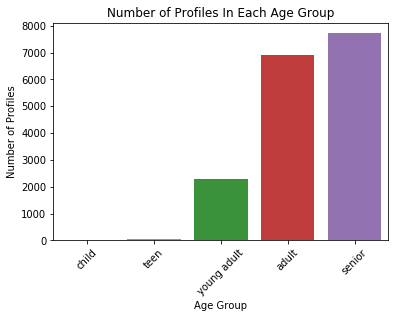

In [85]:
sns.countplot(x='age_groups', data=profile)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show();

### Customer Sign Up

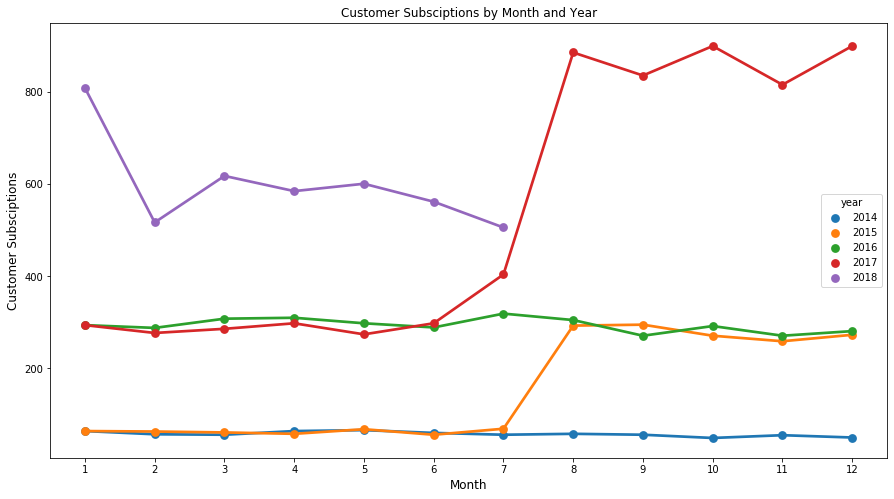

In [19]:
membership_subs = profile[profile['year'] >= 2014].groupby(['year','month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

### Customer Transaction

In [20]:
# Different events in transaction
transcript['event'].value_counts(normalize = True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [21]:
#for completed offers
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

### 4) Data Featuring


In [22]:
# All transaction in transaction in transcript file
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

C:\Users\songc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,person,event,value,time,value_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [23]:
# Obtain received offers and completed offers
test_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )

# Make sure that the time values are converted to floats / integers
test_completion['time_y'] = test_completion['time_y'].apply(lambda x: float(x))
test_completion['time_x'] = test_completion['time_x'].apply(lambda x: float(x))

In [24]:
# Check completed offers
completion = test_completion[
    (
        (test_completion['time_y'] <= (test_completion['time_x'] + 20)) # Completion date is within max time frame
        & (test_completion['time_y'] >= test_completion['time_x'])  # Completion date is after offer received
    )
    
    | # or 
    
    (pd.isnull(test_completion['event_y']) == True) # Null values to show offers that were never completed
        ][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x'] 
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [26]:
# Merge the completed / non completed offers and what type of offer they were
offers_final_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_final_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_final_df['NetReward'] = offers_final_df['reward'] - offers_final_df['difficulty']
offers_final_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


In [74]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
overall_offers_df['NetWorth'] = (overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward']) * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In [42]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers', 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    # Get Individual profile info
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    # Get transaction aggregates
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = personal_transactions.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] # First and Last Purchase
            , 'value': ['mean', 'sum'] # Average Purchase Amount, total purchase amount
            , 'DaysFromLastPurchase': ['median', 'mean'] # Average days between purchases  
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) # Gets rid of the multi leveling columns
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    # Bring together the transaction aggregates and the profile values
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) # Get rid of the ID column
    
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_final_df[(offers_final_df['person'] == person)
                       & (offers_final_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    # Bring together the bogo and discount values, and include the number of informational promos they received
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_final_df[(offers_final_df['person'] == person)
                                                               & (offers_final_df['offer_type'] == 'informational')])
    
    # Bring everything together
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    # Add personal df to the rest of the customer dataframe
    df_all_customers = df_all_customers.append(person_final)

In [44]:
df_all_customers.head()

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,gender,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,72000.000000,2017-04-21,8,228,696,15.950000,127.60,57.0,87.0
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,NA,65404.991568,2018-04-25,3,294,474,1.363333,4.09,162.0,158.0
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,57000.000000,2018-01-09,5,132,654,15.892000,79.46,120.0,130.8
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,F,90000.000000,2016-03-04,8,54,708,24.607500,196.86,42.0,88.5
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,60000.000000,2016-11-11,12,42,672,12.837500,154.05,39.0,56.0


### 4) Modeling

In [56]:
df_customers=df_all_customers 

In [45]:
final_df = df_all_customers.reset_index()

In [46]:
final_df = pd.get_dummies(data=final_df, columns=['gender'])

In [47]:
final_df['age_groups'] = pd.cut(final_df.age, bins=[0, 12, 18, 35, 60, 200], labels=['child', 'teen', 'young adult', 'adult', 'senior'])
final_df = pd.get_dummies(data=final_df, columns=['age_groups'])

In [48]:
final_df = final_df.drop(['index','age','member_date','person'],axis=1)
final_df=final_df.fillna(0)

In [55]:
final_df.head()

,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,bogo_completed_offers,...,avg_days_between_purchases,gender_F,gender_M,gender_NA,gender_O,age_groups_child,age_groups_teen,age_groups_young adult,age_groups_adult,age_groups_senior
0,1,1.0,0.0,0.0,1,0.0,-8.0,1,1.0,1,...,87.0,0,1,0,0,0,0,1,0,0
1,0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0,...,158.0,0,0,1,0,0,0,0,0,1
2,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,...,130.8,0,0,0,1,0,0,0,1,0
3,0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0,...,88.5,1,0,0,0,0,0,0,1,0
4,0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,...,56.0,1,0,0,0,0,0,1,0,0


In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features=scaler.fit_transform(final_df)
features=pd.DataFrame(features,columns=['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers', 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions',
        'avg_days_between_purchases','avg_transaction','income','max_transaction_day','median_days_between_purchases',
        'min_transaction_day','total_transaction_amount','total_transactions','gender_F','gender_M','gender_NA','gender_O',
         'age_groups_child','age_groups_teen','age_groups_young adult','age_groups_adult','age_groups_senior'])

In [53]:
features.head()

,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,bogo_completed_offers,...,total_transactions,gender_F,gender_M,gender_NA,gender_O,age_groups_child,age_groups_teen,age_groups_young adult,age_groups_adult,age_groups_senior
0,0.166667,1.0,0.0,0.0,0.25,0.0,0.466667,0.166667,1.0,0.2,...,0.121849,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.00,0.0,1.000000,0.333333,0.0,0.0,...,0.221289,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.0,0.0,0.0,0.00,0.0,1.000000,0.000000,0.0,0.0,...,0.183193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.0,0.0,0.0,0.00,0.0,1.000000,0.166667,0.0,0.0,...,0.123950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.0,0.0,0.0,0.00,0.0,1.000000,0.000000,0.0,0.0,...,0.078431,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


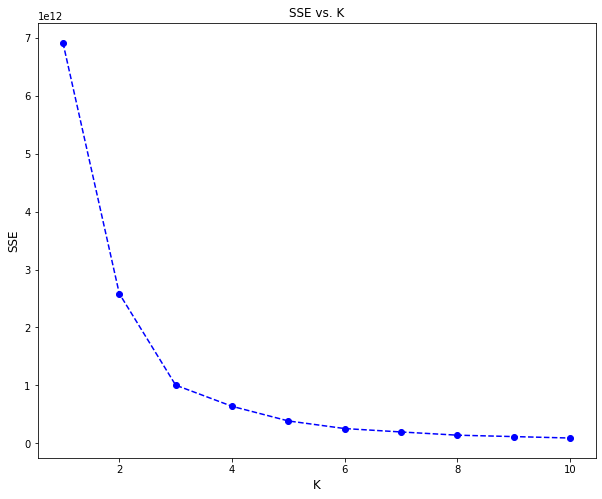

In [54]:
from sklearn.cluster import KMeans
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(final_df)
    
    scores.append(abs(model.score(final_df)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

In [57]:
from sklearn import cluster
clust = cluster.AgglomerativeClustering(3, linkage='ward')

# Set the Cluster 3 column with the cluster predictions of the clustering algorithm
df_customers['Cluster_3'] = clust.fit_predict(features)

In [58]:
df_customers.head()

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,Cluster_3
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,72000.000000,2017-04-21,8,228,696,15.950000,127.60,57.0,87.0,2
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,65404.991568,2018-04-25,3,294,474,1.363333,4.09,162.0,158.0,1
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57000.000000,2018-01-09,5,132,654,15.892000,79.46,120.0,130.8,0
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,90000.000000,2016-03-04,8,54,708,24.607500,196.86,42.0,88.5,0
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.000000,2016-11-11,12,42,672,12.837500,154.05,39.0,56.0,2


In [59]:
df_customers.Cluster_3.value_counts(normalize = True)

0    0.477765
2    0.291824
1    0.230412
Name: Cluster_3, dtype: float64

<Figure size 1440x720 with 0 Axes>

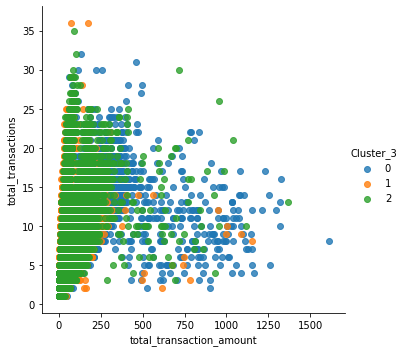

In [60]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Cluster_3'
           , data=df_customers, fit_reg=False);

<Figure size 1440x1440 with 0 Axes>

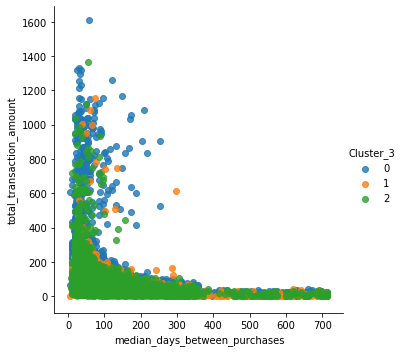

In [61]:
plt.figure(figsize = (20,20));
sns.lmplot(x='median_days_between_purchases', y='total_transaction_amount', hue='Cluster_3'
           , data=df_customers, fit_reg=False);

In [67]:
clust_offer_aggs = pd.merge(offers_final_df, df_customers[['person','Cluster_3']]).groupby(
                            ['Cluster_3','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

clust_offer_aggs = clust_offer_aggs[clust_offer_aggs['offer_type'] != 'informational']
clust_offer_aggs.columns.droplevel(1)
clust_offer_aggs.columns = ['Cluster_3','offer_type','difficulty','reward'
                           , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [68]:
clust_offer_aggs.head()

,Cluster_3,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.602638,2193,8.577291,0
1,0,bogo,10,10,0.510650,1918,9.053180,0
2,0,discount,7,3,0.704478,1180,8.913559,-4
3,0,discount,10,2,0.599481,1847,8.946400,-8
4,0,discount,20,5,0.255066,365,9.369863,-15


In [69]:
def bogo_or_discount(row):
    """
    Checks the overall population average of completed offers for that specifc offer type
    and compares it to the cluster's completion type. Returns the promotional data type that should be offered
    if clustered average success rate is greater than average success rate within a 5% buffer
    
    INPUT - row (full row of the data frame)
    OUTPUT - string (discount or bogo)
    
    """
    offer_type = row['offer_type']
    cluster_val = row['ClusterCompletedOffers']
    avg_val = row['AvgCompletedOffers']
    
    if cluster_val + .05 > avg_val:
        return 'discount'
    else:
        return 'bogo'

In [75]:
final_comparisons = pd.merge(clust_offer_aggs
         , final_overall_offers_df[['offer_type','difficulty','reward', 'CompletedOffers']]
         , how = 'inner'
         , on = ['offer_type','difficulty','reward']
        ).sort_values(['Cluster_3','offer_type','difficulty','reward'])
final_comparisons.columns = ['Cluster_3', 'offer_type', 'difficulty', 'reward', 'ClusterCompletedOffers',
       'TotalCompletions', 'AvgDaysToCompleteOffer', 'NetReward',
       'AvgCompletedOffers']

final_comparisons['BOGO_or_Discount'] = final_comparisons.apply(bogo_or_discount, axis = 1)
final_comparisons[['Cluster_3', 'offer_type', 'difficulty', 'reward'
                  , 'ClusterCompletedOffers','AvgCompletedOffers','BOGO_or_Discount']
                 ].set_index(['Cluster_3','offer_type'
                            ,'difficulty', 'reward'])

ClusterCompletedOffers  \
Cluster_3 offer_type difficulty reward                           
0         bogo       5          5                     0.602638   
                     10         10                    0.510650   
          discount   7          3                     0.704478   
                     10         2                     0.599481   
                     20         5                     0.255066   
1         bogo       5          5                     0.032881   
                     10         10                    0.003405   
          discount   7          3                     0.012308   
                     10         2                     0.003289   
                     20         5                     0.000704   
2         bogo       5          5                     0.139857   
                     10         10                    0.069366   
          discount   7          3                     0.189310   
                     10         2                     0.095326   
                     20         5                     0.017834   

                                        AvgCompletedOffers BOGO_or_Discount  
Cluster_3 offer_type difficulty reward                                       
0         bogo       5          5                 0.308293         discount  
                     10         10                0.217532         discount  
          discount   7          3                 0.383878         discount  
                     10         2                 0.279512         discount  
                     20         5                 0.090034         discount  
1         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034             bogo  
2         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034             bogo

### 5) Conclusion

In this project, I tried to analyze and make model to predict the best offer to give a Starbucks customer. First I explored the data and see what I have to change before start the analysis. Then I did some exploratory analysis on the data after cleaning. In conclusion, the company should give more offers to Females than Males since they have more completed offers. And they should focus more on BOGO and Discount offers since they are the one that tend to make customers buy more.